In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import time
import os
from functools import wraps

from dataclasses import dataclass

In [2]:
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.2f}".format)

# Common

In [3]:
def mean_absolute_percentage_error(y_true: list[float], y_pred: list[float]) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load Dataset

In [4]:
UNIQUE_ID = "unique_id"
SEPARATOR = "_"
file_name = "data.csv"
n = 2

In [5]:
df = pd.read_csv(file_name, delimiter=";")
df.head()

,Reporting Economy,Product/Sector,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,World,SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,16554643.00,16036335.00,17741325.00,19550037.00,19017108.00,17653275.00,22365766.00,24925766.00
1,World,SI3_AGG - AG - Agricultural products,847715.00,942450.00,1131691.00,1342823.00,1177136.00,1354429.00,1649389.00,1655099.00,1731531.00,1746687.00,1565686.00,1585693.00,1731381.00,1810271.00,1788200.00,1809475.00,2148665.00,2325521.00
2,World,SI3_AGG - AGFO - Food,680936.00,753836.00,915653.00,1114698.00,998004.00,1115790.00,1350316.00,1369778.00,1445339.00,1480252.00,1332886.00,1357202.00,1473948.00,1533561.00,1533159.00,1573538.00,1836335.00,2007666.00
3,World,SI3_AGG - MI - Fuels and mining products,1810185.00,2319402.00,2674500.00,3554158.00,2299789.00,3074398.00,4122493.00,4164125.00,4051300.00,3720251.00,2380017.00,2033684.00,2611396.00,3264056.00,3102597.00,2326889.00,3670710.00,4950975.00
4,World,SI3_AGG - MIFU - Fuels,1457315.00,1801129.00,2047440.00,2884170.00,1838528.00,2395065.00,3268505.00,3399965.00,3309479.00,3026072.00,1808811.00,1492255.00,1948478.00,2528513.00,2370333.00,1571511.00,2555970.00,3865877.00


# Preprocessing

Since currently we are not handling the missing data, let's only take the columns with no null columns

## General DataFrame Preprocessing

In [6]:
def create_unique_id(df: pd.DataFrame, n: int) -> pd.DataFrame:
    columns = list(df.columns)
    columns = columns[:n]
    df[UNIQUE_ID] = df[columns].apply(
        lambda row: SEPARATOR.join(row.values.astype(str)), axis=1
    )
    cols = list(df.columns)
    cols.insert(0, cols.pop(cols.index(UNIQUE_ID)))
    df = df[cols]
    df = df.drop(columns=columns, axis=1)
    return df

In [7]:
df = create_unique_id(df, n)
df.head()

,unique_id,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,16554643.00,16036335.00,17741325.00,19550037.00,19017108.00,17653275.00,22365766.00,24925766.00
1,World_SI3_AGG - AG - Agricultural products,847715.00,942450.00,1131691.00,1342823.00,1177136.00,1354429.00,1649389.00,1655099.00,1731531.00,1746687.00,1565686.00,1585693.00,1731381.00,1810271.00,1788200.00,1809475.00,2148665.00,2325521.00
2,World_SI3_AGG - AGFO - Food,680936.00,753836.00,915653.00,1114698.00,998004.00,1115790.00,1350316.00,1369778.00,1445339.00,1480252.00,1332886.00,1357202.00,1473948.00,1533561.00,1533159.00,1573538.00,1836335.00,2007666.00
3,World_SI3_AGG - MI - Fuels and mining products,1810185.00,2319402.00,2674500.00,3554158.00,2299789.00,3074398.00,4122493.00,4164125.00,4051300.00,3720251.00,2380017.00,2033684.00,2611396.00,3264056.00,3102597.00,2326889.00,3670710.00,4950975.00
4,World_SI3_AGG - MIFU - Fuels,1457315.00,1801129.00,2047440.00,2884170.00,1838528.00,2395065.00,3268505.00,3399965.00,3309479.00,3026072.00,1808811.00,1492255.00,1948478.00,2528513.00,2370333.00,1571511.00,2555970.00,3865877.00


In [8]:
def rename_duplicates(df: pd.DataFrame) -> pd.DataFrame:
    df_grouped = df.groupby(UNIQUE_ID)
    df_grouped = df_grouped.filter(lambda x: len(x) > 1)

    unique_ids = df_grouped[UNIQUE_ID].unique()
    df = df.copy()
    for unique_id in unique_ids:
        rows = df_grouped[df_grouped[UNIQUE_ID] == unique_id]
        # TODO: This is hardcoded. We should find a way to sort the columns dynamically
        rows = rows.sort_values(by=["2005", "2006", "2007", "2022"], ascending=False)
        for i, row_index in enumerate(rows.index):
            if i == 0:
                df = df.drop(row_index)
            else:
                df.loc[row_index, UNIQUE_ID] = f"{unique_id}_{i+1}"
    return df

In [9]:
df = rename_duplicates(df)

In [10]:
df = df.set_index(UNIQUE_ID)
df = df.transpose()
df.head()

unique_id,World_SI3_AGG - TO - Total merchandise,World_SI3_AGG - AG - Agricultural products,World_SI3_AGG - AGFO - Food,World_SI3_AGG - MI - Fuels and mining products,World_SI3_AGG - MIFU - Fuels,World_SI3_AGG - MA - Manufactures,World_SI3_AGG - MAIS - Iron and steel,World_SI3_AGG - MACH - Chemicals,World_SI3_AGG - MACHPH - Pharmaceuticals,World_SI3_AGG - MAMT - Machinery and transport equipment,...,Zimbabwe_SI3_AGG - MACHPH - Pharmaceuticals,Zimbabwe_SI3_AGG - MAMT - Machinery and transport equipment,Zimbabwe_SI3_AGG - MAMTOF - Office and telecom equipment,Zimbabwe_SI3_AGG - MAMTOTEP - Electronic data processing and office equipment,Zimbabwe_SI3_AGG - MAMTOTTL - Telecommunications equipment,Zimbabwe_SI3_AGG - MAMTOTIC - Integrated circuits and electronic components,Zimbabwe_SI3_AGG - MAMTTE - Transport equipment,Zimbabwe_SI3_AGG - MAMTAU - Automotive products,Zimbabwe_SI3_AGG - MATE - Textiles,Zimbabwe_SI3_AGG - MACL - Clothing
2005,10510291.00,847715.00,680936.00,1810185.00,1457315.00,7302724.00,316470.00,1101752.00,275127.00,3855720.00,...,3.00,28.00,2.00,1.00,1.00,0.00,8.00,6.00,14.00,7.00
2006,12131279.00,942450.00,753836.00,2319402.00,1801129.00,8263994.00,375338.00,1244851.00,313193.00,4381947.00,...,3.00,228.00,11.00,10.00,1.00,0.00,165.00,16.00,23.00,17.00
2007,14031816.00,1131691.00,915653.00,2674500.00,2047440.00,9533196.00,479301.00,1478222.00,372901.00,4975712.00,...,2.00,206.00,11.00,3.00,7.00,0.00,84.00,28.00,67.00,18.00
2008,16168718.00,1342823.00,1114698.00,3554158.00,2884170.00,10475820.00,588219.00,1684177.00,420731.00,5363885.00,...,1.00,177.00,3.00,2.00,0.00,1.00,90.00,77.00,74.00,47.00
2009,12564776.00,1177136.00,998004.00,2299789.00,1838528.00,8379712.00,326017.00,1453993.00,438048.00,4219363.00,...,2.00,85.00,13.00,1.00,5.00,7.00,16.00,10.00,17.00,16.00


In [11]:
df = df.reset_index()
df = df.rename(columns={"index": "year"})
df.head()

unique_id,year,World_SI3_AGG - TO - Total merchandise,World_SI3_AGG - AG - Agricultural products,World_SI3_AGG - AGFO - Food,World_SI3_AGG - MI - Fuels and mining products,World_SI3_AGG - MIFU - Fuels,World_SI3_AGG - MA - Manufactures,World_SI3_AGG - MAIS - Iron and steel,World_SI3_AGG - MACH - Chemicals,World_SI3_AGG - MACHPH - Pharmaceuticals,...,Zimbabwe_SI3_AGG - MACHPH - Pharmaceuticals,Zimbabwe_SI3_AGG - MAMT - Machinery and transport equipment,Zimbabwe_SI3_AGG - MAMTOF - Office and telecom equipment,Zimbabwe_SI3_AGG - MAMTOTEP - Electronic data processing and office equipment,Zimbabwe_SI3_AGG - MAMTOTTL - Telecommunications equipment,Zimbabwe_SI3_AGG - MAMTOTIC - Integrated circuits and electronic components,Zimbabwe_SI3_AGG - MAMTTE - Transport equipment,Zimbabwe_SI3_AGG - MAMTAU - Automotive products,Zimbabwe_SI3_AGG - MATE - Textiles,Zimbabwe_SI3_AGG - MACL - Clothing
0,2005,10510291.00,847715.00,680936.00,1810185.00,1457315.00,7302724.00,316470.00,1101752.00,275127.00,...,3.00,28.00,2.00,1.00,1.00,0.00,8.00,6.00,14.00,7.00
1,2006,12131279.00,942450.00,753836.00,2319402.00,1801129.00,8263994.00,375338.00,1244851.00,313193.00,...,3.00,228.00,11.00,10.00,1.00,0.00,165.00,16.00,23.00,17.00
2,2007,14031816.00,1131691.00,915653.00,2674500.00,2047440.00,9533196.00,479301.00,1478222.00,372901.00,...,2.00,206.00,11.00,3.00,7.00,0.00,84.00,28.00,67.00,18.00
3,2008,16168718.00,1342823.00,1114698.00,3554158.00,2884170.00,10475820.00,588219.00,1684177.00,420731.00,...,1.00,177.00,3.00,2.00,0.00,1.00,90.00,77.00,74.00,47.00
4,2009,12564776.00,1177136.00,998004.00,2299789.00,1838528.00,8379712.00,326017.00,1453993.00,438048.00,...,2.00,85.00,13.00,1.00,5.00,7.00,16.00,10.00,17.00,16.00


In [12]:
until_year = 2019
size = df[pd.to_datetime(df["year"]).dt.year > until_year].shape[0]
test_ratio = size / df.shape[0]
print(f"Test ratio: {test_ratio}\n")

Test ratio: 0.16666666666666666



In [13]:
df = df.dropna(axis=1, how="any") # Drop columns with NaN values

In [14]:
def general_preprocessing(df: pd.DataFrame, n: int) -> pd.DataFrame:
    df = create_unique_id(df, n)

    df = df.set_index(UNIQUE_ID)
    df = df.transpose()

    df = df.reset_index()
    df = df.rename(columns={"index": "year"})

    # Drop columns with NaN values
    df = df.dropna(axis=1, how="any")
    
    return df

## Column Preprocessing

In [15]:
unique_ids = list(df.columns[1:])

In [16]:
CURRENT_UNIQUE_ID = unique_ids[0]

In [17]:
data = df[["year", CURRENT_UNIQUE_ID]]
data = data.rename(columns={CURRENT_UNIQUE_ID: "rate"})
data.head()

unique_id,year,rate
0,2005,10510291.00
1,2006,12131279.00
2,2007,14031816.00
3,2008,16168718.00
4,2009,12564776.00


In [18]:
def process_single_series(single_series):
    data = single_series.copy()
    data.columns = ["date", "rate"]
    data["rate"] = data["rate"].astype(str)

    data["rate"] = data.rate.replace("ND", np.nan)

    data["date"] = pd.to_datetime(data["date"], format="%Y")
    data["rate"] = pd.to_numeric(data["rate"])

    # handling missing values (interpolation)
    data["rate"] = data["rate"].interpolate()

    data = data.resample("YS", on="date", label="left", closed="left").mean()

    # gradualize the data by linearly interpolating the data
    data = data.resample("D").asfreq()
    data = data.interpolate(method="linear")

    data["time"] = [i + 1 for i in range(len(data))]

    return data

In [19]:
data = process_single_series(data)
data.head()

,rate,time
date,,
2005-01-01,10510291.00,1
2005-01-02,10514732.06,2
2005-01-03,10519173.13,3
2005-01-04,10523614.19,4
2005-01-05,10528055.25,5


# Train Models

In [20]:
from dataclasses import dataclass

@dataclass
class ModelResult:
    model: object
    train_values: np.array
    test_values: np.array
    predictions: np.array
    mape: float

## Linear Regression

In [21]:
def train_test_split(data, test_ratio = 0.2):
    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    X_train = train.drop('rate',axis=1)
    X_test = test.drop('rate',axis=1)
    y_train = train[['rate']]
    y_test = test[['rate']]

    return X_train, X_test, y_train, y_test

In [22]:
from sklearn.linear_model import LinearRegression

def get_linear_regression_prediction(data : pd.DataFrame, test_ratio = 0.2) -> ModelResult:
    X_train, X_test, y_train, y_test = train_test_split(data, test_ratio)

    model = LinearRegression()
    model.fit(X = X_train, y = y_train)
    predictions = model.predict(X_test)

    predictions = predictions.reshape(-1)

    linear_reg_mape = mean_absolute_percentage_error(y_test.values.reshape(-1), predictions)

    return ModelResult(
        model,
        y_train.values.reshape(-1),
        y_test.values.reshape(-1),
        predictions,
        linear_reg_mape
    )

In [23]:
# linear_reg_result = get_linear_regression_prediction(data)
# print(f"Linear Regression MAPE: {linear_reg_result.mape}")

## ARIMA

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
def get_arima_prediction(data, test_ratio = 0.2, order = (3,1,2)) -> ModelResult:
    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    predictions = []

    arima = ARIMA(train.rate,order=order).fit()

    horizon = len(test)
    predictions.append(arima.forecast(horizon))
    predictions = np.array(predictions[0]).reshape((horizon,))

    predictions = predictions.reshape(-1)

    arima_mape = mean_absolute_percentage_error(test.rate, predictions)

    return ModelResult(
        arima,
        train.rate.values.reshape(-1),
        test.rate.values.reshape(-1),
        predictions,
        arima_mape
    )

In [26]:
# arima_reg_result = get_arima_prediction(data)
# print(f"ARIMA Regression MAPE: {arima_reg_result.mape}")

## Prophet

In [27]:
from prophet import Prophet

In [28]:
@dataclass
class ProphetModelResult(ModelResult):
    forecast: pd.DataFrame

In [29]:
def get_prophet_prediction(data, test_ratio = 0.2, interval_width=0.95) -> ProphetModelResult:
    data = data.reset_index()
    data = data.rename(columns={'date' : 'ds','rate' : 'y'})
    data = data[['ds', 'y']]

    train_size = int(len(data) * (1 - test_ratio))
    train = data[:train_size]
    test = data[train_size:]

    my_model = Prophet(interval_width=interval_width)
    my_model.fit(train)

    future_dates = my_model.make_future_dataframe(periods=len(test), freq='D')

    forecast = my_model.predict(future_dates)

    predictions = forecast.yhat[train_size:].values.reshape(-1)

    prophet_mape = mean_absolute_percentage_error(test.y, predictions)

    return ProphetModelResult(
        my_model,
        train.y.values.reshape(-1),
        test.y.values.reshape(-1),
        predictions,
        prophet_mape,
        forecast
    )

In [30]:
# prophet_reg_result = get_prophet_prediction(data)
# print(f"Prophet Regression MAPE: {prophet_reg_result.mape}")

## LSTM

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [32]:
data.tail()

,rate,time
date,,
2021-12-28,24897711.21,6206
2021-12-29,24904724.90,6207
2021-12-30,24911738.60,6208
2021-12-31,24918752.30,6209
2022-01-01,24925766.00,6210


In [33]:
def add_rows(data: pd.DataFrame, n: int) -> pd.DataFrame:
    added_df: pd.DataFrame = data.copy()
    last_row = added_df.index[-1]
    for i in range(n):
        last_row = last_row + DateOffset(days=1)
        added_df.loc[last_row] = np.nan

    added_df = added_df.interpolate(method="linear")
    return added_df

In [34]:
# the side effect of this is, that it actually removes look_back number of columns

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	# for i in range(len(dataset)-look_back-1):
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [35]:
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(data)
    return dataset, scaler

In [36]:
def split_lstm_train_test(data, test_ratio = 0.2, look_back=1):
    train_size = int(len(data) * (1 - test_ratio))
    train, test = data[0:train_size,:], data[train_size:len(data),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    return trainX, trainY, testX, testY

In [37]:
def get_trained_model(trainX, trainY, look_back, epochs=5):
    model = Sequential()

    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)

    return model

In [38]:
def get_lstm_prediction(data, epochs=5, look_back = 1, test_ratio = 0.2) -> ModelResult:
    data = add_rows(data, look_back)
    dataset = data.rate.values
    dataset = dataset.astype('float32').reshape(-1,1)

    dataset, scaler = normalize_data(dataset)
    trainX, trainY, testX, testY = split_lstm_train_test(dataset, test_ratio, look_back)

    # create and fit the LSTM network
    model = get_trained_model(trainX, trainY, look_back, epochs=epochs)

    # make predictions
    prediction = model.predict(testX)

    # invert normalization
    trainY = scaler.inverse_transform([trainY])
    testY = scaler.inverse_transform([testY])
    prediction = scaler.inverse_transform(prediction)

    prediction = prediction.reshape(-1)

    lstm_mape = mean_absolute_percentage_error(testY.reshape(-1), prediction)

    return ModelResult(
        model,
        trainY.reshape(-1),
        testY.reshape(-1),
        prediction,
        lstm_mape
    )

In [39]:
# lstm_model_result = get_lstm_prediction(data, epochs=1, test_ratio = 0.2)
# print(f"LSTM MAPE: {lstm_model_result.mape}")

# End-to-End

In [40]:
until_year = 2019
size = df[pd.to_datetime(df["year"]).dt.year > until_year].shape[0]
test_ratio = size / df.shape[0]
print(f"Test ratio: {test_ratio}\n")

Test ratio: 0.16666666666666666



In [41]:
def train_all_models(data, test_ratio=test_ratio):
    test_size = int(len(data) * test_ratio)
    train, test = data[:-test_size], data[-test_size:]

    # print("Linear Regression Model Started")
    # linear_regression_result = get_linear_regression_prediction(data, test_ratio=test_ratio)

    print("\n\nARIMA Prediction Started")
    arima_result = get_arima_prediction(data, test_ratio=test_ratio)

    print("\n\nProphet Prediction Started")
    prophet_result = get_prophet_prediction(data, test_ratio=test_ratio)

    print("\n\nLSTM Prediction Started")
    lstm_result = get_lstm_prediction(data, test_ratio=test_ratio, epochs=2)

    return {
        "test": test,
        "train": train,
        "models": {
            # "Linear Regression": linear_regression_result,
            "Prophet": prophet_result,
            "ARIMA": arima_result,
            "LSTM": lstm_result
        }

    }

In [42]:
df = pd.read_csv(file_name, delimiter=";")
df = general_preprocessing(df, n)

In [43]:
unique_ids = list(df.columns[1:])
final_df = pd.DataFrame()

In [44]:
MAPE_ROW_NAME = "MAPE"

for unique_id in unique_ids[:3]:
    # Prepare the data
    data = df[["year", unique_id]]
    data = process_single_series(data)

    # Train all models
    print(f"Processing for {unique_id}")
    result = train_all_models(data)

    # Post process the results
    train = results["train"]
    test = results["test"]
    predictions = results["models"]

    max_size = max([pred.predictions.shape[0] for _, pred in predictions.items()])

    ## Get the predictions in the same size by padding with NaN
    same_size_predictions = {}

    for model_name, model_result in predictions.items():
        model_result.predictions = np.pad(
            model_result.predictions, 
            (0, max_size - len(model_result.predictions)), 
            'constant', 
            constant_values=(np.nan)
            )
        same_size_predictions[model_name] = model_result.predictions
    
    ## Create a DataFrame with the predictions
    predictions_df = pd.DataFrame(same_size_predictions)
    predictions_df["year"] = test.index
    predictions_df["year"] = pd.to_datetime(predictions_df["year"])
    predictions_df = predictions_df.set_index("year")
    
    ## Get the predictions for the first day of the years
    pred_df = predictions_df[predictions_df.index.dayofyear == 1]

    mapes = [model_result.mape for _, model_result in predictions.items()]
    pred_df.index = pred_df.index.year
    pred_df.loc[MAPE_ROW_NAME] = mapes

    unstacked_pred_df = pred_df.unstack()
    unstacked_pred_df.index = [
        f"{model}_{year}" for model, year in unstacked_pred_df.index
    ]
    columns = list(unstacked_pred_df.index)
    reshaped_pred_df = unstacked_pred_df.to_frame().T
    reshaped_pred_df.index = [CURRENT_UNIQUE_ID]

    real_df: pd.DataFrame = df[[CURRENT_UNIQUE_ID, "year"]]
    real_df = real_df.set_index("year")
    real_df = real_df.T

    all_df = pd.concat([real_df, reshaped_pred_df], axis=1)
    final_df = pd.concat([final_df, all_df])
    

    

Processing for World_SI3_AGG - TO - Total merchandise


ARIMA Prediction Started


/Users/yahyahaji/Documents/personal-projects/time-series-analysis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




Prophet Prediction Started


22:45:59 - cmdstanpy - INFO - Chain [1] start processing
22:46:00 - cmdstanpy - INFO - Chain [1] done processing




LSTM Prediction Started
Epoch 1/2
5174/5174 - 3s - 530us/step - loss: 0.0060
Epoch 2/2
5174/5174 - 2s - 378us/step - loss: 8.8298e-06
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


NameError: name 'results' is not defined

In [ ]:
final_df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,Prophet_2022,Prophet_MAPE,ARIMA_2020,ARIMA_2021,ARIMA_2022,ARIMA_MAPE,LSTM_2020,LSTM_2021,LSTM_2022,LSTM_MAPE
World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,...,22726921.54,7.98,18558756.04,18458776.81,18426779.46,11.30,17659476.00,22078348.00,NaN,0.92
World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,...,22726921.54,7.98,18558756.04,18458776.81,18426779.46,11.30,17659476.00,22078348.00,NaN,0.92
World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,...,22726921.54,7.98,18558756.04,18458776.81,18426779.46,11.30,17659476.00,22078348.00,NaN,0.92


In [ ]:
results = train_all_models(data)



ARIMA Prediction Started


/Users/yahyahaji/Documents/personal-projects/time-series-analysis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
22:04:57 - cmdstanpy - INFO - Chain [1] start processing




Prophet Prediction Started


22:04:59 - cmdstanpy - INFO - Chain [1] done processing




LSTM Prediction Started
Epoch 1/2
5174/5174 - 3s - 497us/step - loss: 0.0023
Epoch 2/2
5174/5174 - 2s - 381us/step - loss: 2.1977e-06
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
train = results["train"]
test = results["test"]
predictions = results["models"]

In [ ]:
max_size = max([pred.predictions.shape[0] for _, pred in predictions.items()])

In [ ]:
same_size_predictions = {}

for model_name, model_result in predictions.items():
    model_result.predictions = np.pad(
        model_result.predictions, 
        (0, max_size - len(model_result.predictions)), 
        'constant', 
        constant_values=(np.nan)
        )
    same_size_predictions[model_name] = model_result.predictions

In [ ]:
predictions_df = pd.DataFrame(same_size_predictions)
predictions_df["year"] = test.index
predictions_df["year"] = pd.to_datetime(predictions_df["year"])
predictions_df = predictions_df.set_index("year")
predictions_df.head()

,Prophet,ARIMA,LSTM
year,,,
2019-03-04,19890775.64,18788090.89,18814780.00
2019-03-05,19896799.18,18787000.41,18811148.00
2019-03-06,19902817.95,18785906.64,18807518.00
2019-03-07,19908794.25,18784810.14,18803886.00
2019-03-08,19914716.88,18783711.45,18800254.00


<Axes: xlabel='year'>

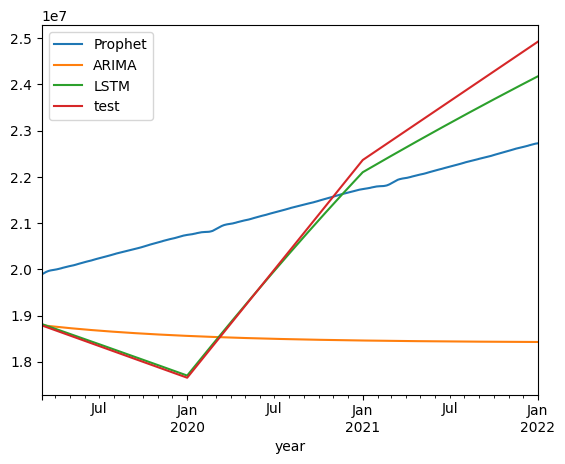

In [ ]:
predictions_df["test"] = test.rate.values
predictions_df.plot()

# Post Processing

## Reshape To Single Row

In [ ]:
MAPE_ROW_NAME = "MAPE"

In [ ]:
pred_df = predictions_df.copy()
pred_df = pred_df.drop(columns=["test"])
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1035 entries, 2019-03-04 to 2022-01-01
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Prophet  1035 non-null   float64
 1   ARIMA    1035 non-null   float64
 2   LSTM     1034 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 28.3 KB


In [ ]:
pred_df.head()

,Prophet,ARIMA,LSTM
year,,,
2019-03-04,19890775.64,18788090.89,18814780.00
2019-03-05,19896799.18,18787000.41,18811148.00
2019-03-06,19902817.95,18785906.64,18807518.00
2019-03-07,19908794.25,18784810.14,18803886.00
2019-03-08,19914716.88,18783711.45,18800254.00


In [ ]:
pred_df = pred_df[pred_df.index.dayofyear == 1]
pred_df.head()

,Prophet,ARIMA,LSTM
year,,,
2020-01-01,20744430.01,18558756.04,17699884.00
2021-01-01,21736346.82,18458776.81,22101388.00
2022-01-01,22726921.54,18426779.46,NaN


In [ ]:
mapes = {model_name: model_result.mape for model_name, model_result in predictions.items()}
mapes = list(mapes.values())
mapes

[7.9834577579591155, 11.303661183300024, 0.936852547003577]

In [ ]:
pred_df.index = pred_df.index.year

In [ ]:
pred_df.loc[MAPE_ROW_NAME] = mapes
pred_df.head()

,Prophet,ARIMA,LSTM
year,,,
2020,20744430.01,18558756.04,17699884.00
2021,21736346.82,18458776.81,22101388.00
2022,22726921.54,18426779.46,NaN
MAPE,7.98,11.30,0.94


In [ ]:
unstacked_pred_df = pred_df.unstack()
unstacked_pred_df.index = [
    f"{model}_{year}" for model, year in unstacked_pred_df.index
]
columns = list(unstacked_pred_df.index)
reshaped_pred_df = unstacked_pred_df.to_frame().T
reshaped_pred_df.index = [CURRENT_UNIQUE_ID]
reshaped_pred_df.head() 

,Prophet_2020,Prophet_2021,Prophet_2022,Prophet_MAPE,ARIMA_2020,ARIMA_2021,ARIMA_2022,ARIMA_MAPE,LSTM_2020,LSTM_2021,LSTM_2022,LSTM_MAPE
World_SI3_AGG - TO - Total merchandise,20744430.01,21736346.82,22726921.54,7.98,18558756.04,18458776.81,18426779.46,11.30,17699884.00,22101388.00,NaN,0.94


In [ ]:
reshaped_pred_df.shape

(1, 12)

In [ ]:
df.head()

unique_id,year,World_SI3_AGG - TO - Total merchandise,World_SI3_AGG - AG - Agricultural products,World_SI3_AGG - AGFO - Food,World_SI3_AGG - MI - Fuels and mining products,World_SI3_AGG - MIFU - Fuels,World_SI3_AGG - MA - Manufactures,World_SI3_AGG - MAIS - Iron and steel,World_SI3_AGG - MACH - Chemicals,World_SI3_AGG - MACHPH - Pharmaceuticals,...,Zambia_SI3_AGG - MAMT - Machinery and transport equipment,Zambia_SI3_AGG - MAMTOF - Office and telecom equipment,Zambia_SI3_AGG - MAMTOTEP - Electronic data processing and office equipment,Zambia_SI3_AGG - MAMTOTTL - Telecommunications equipment,Zambia_SI3_AGG - MAMTOTIC - Integrated circuits and electronic components,Zambia_SI3_AGG - MAMTTE - Transport equipment,Zambia_SI3_AGG - MAMTAU - Automotive products,Zambia_SI3_AGG - MATE - Textiles,Zambia_SI3_AGG - MACL - Clothing,Zimbabwe_SI3_AGG - TO - Total merchandise
0,2005,10510291.00,847715.00,680936.00,1810185.00,1457315.00,7302724.00,316470.00,1101752.00,275127.00,...,28.00,1.00,0.00,1.00,0.00,3.00,2.00,24.00,4.00,1850.00
1,2006,12131279.00,942450.00,753836.00,2319402.00,1801129.00,8263994.00,375338.00,1244851.00,313193.00,...,112.00,2.00,1.00,1.00,0.00,7.00,4.00,21.00,0.00,2000.00
2,2007,14031816.00,1131691.00,915653.00,2674500.00,2047440.00,9533196.00,479301.00,1478222.00,372901.00,...,127.00,9.00,2.00,7.00,0.00,27.00,20.00,25.00,1.00,2400.00
3,2008,16168718.00,1342823.00,1114698.00,3554158.00,2884170.00,10475820.00,588219.00,1684177.00,420731.00,...,143.00,6.00,1.00,5.00,0.00,26.00,19.00,8.00,0.00,2200.00
4,2009,12564776.00,1177136.00,998004.00,2299789.00,1838528.00,8379712.00,326017.00,1453993.00,438048.00,...,139.00,4.00,1.00,3.00,0.00,36.00,29.00,1.00,1.00,2269.00


In [ ]:
real_df: pd.DataFrame = df[[CURRENT_UNIQUE_ID, "year"]]
real_df = real_df.set_index("year")
real_df = real_df.T
real_df.head()

year,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
unique_id,,,,,,,,,,,,,,,,,,
World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,16554643.00,16036335.00,17741325.00,19550037.00,19017108.00,17653275.00,22365766.00,24925766.00


In [ ]:
all_df = pd.concat([real_df, reshaped_pred_df], axis=1)
all_df.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,Prophet_2022,Prophet_MAPE,ARIMA_2020,ARIMA_2021,ARIMA_2022,ARIMA_MAPE,LSTM_2020,LSTM_2021,LSTM_2022,LSTM_MAPE
World_SI3_AGG - TO - Total merchandise,10510291.00,12131279.00,14031816.00,16168718.00,12564776.00,15301659.00,18337603.00,18508981.00,18958769.00,18999593.00,...,22726921.54,7.98,18558756.04,18458776.81,18426779.46,11.30,17699884.00,22101388.00,NaN,0.94
